# Semi Supervised Learning Normalising Flow 

Here we aim to get probability memberships for stars in a cluster based on a semi supevised learning method. The method uses the GMM Flow model. We use stars as classified with extreme high probabiliity from the XDGMM model to label data as beign in the cluster. Moreover we use best isochrone fit to to find more stars which are almost perfect fits. Importantlly we also use this information to label stars which are almost definitely not in the cluster and are field stars. From here we use this information to do a Semi Supervised fit using the GMM Flow

In [72]:
from astropy.io import fits
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../Data_handling")

from RealNVP import FlowGMM
from gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from vae import Encoder,Decoder, VAE , loss_function, model_train
from sp_vae import ModelVAE,model_trains
from gmm_torch import GaussianMixture

os.chdir("../Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

In [73]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  

### Import Data

In [74]:
os.chdir('../cluster_files')
nf_data=pd.read_csv('vae_data.csv')
os.chdir('../Cluster_analysis')

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_60573/3296965813.py:2: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  nf_data=pd.read_csv('vae_data.csv')


### Parameters of Interest

In [75]:
columns=['ra','dec','parallax','VRAD','pmra','pmdec','bp_g','g_rp',
'ra_error','dec_error','parallax_error','pmra_error','pmdec_error','phot_g_mean_flux'
,'mean_absolute_mag_g_band','bp_rp','prob'
,'parallax_over_error','phot_g_mean_flux_error','phot_bp_mean_flux_error','phot_rp_mean_flux_error'
,'phot_g_mean_flux_over_error','phot_bp_mean_flux_over_error','phot_rp_mean_flux_over_error','rgeo']


In [76]:
nf_data=nf_data[columns].dropna().reset_index(drop=True)

# Semi Supervised Learning Labelling

We are going to choose stars with the XGDM prob < 1e-50 to be field stars.
We will choose stars with prob >0.999 as being cluster stars

In [77]:
nf_data['l1']=nf_data['prob']>=0.99
nf_data['l2']=nf_data['prob']<1e-50

In [78]:
nf_data['l2'].sum()
nf_data[['l1','l2']]=nf_data[['l1','l2']].astype(int)
nf_data=nf_data.reset_index()
nf_data['l3']=nf_data['l1'] + nf_data['l2']-1
nf_data['labels']=0*nf_data['l1']+nf_data['l2']*1+nf_data['l3']

In [79]:
nf_data = nf_data.sample(frac=1).reset_index(drop=True)
x=nf_data[nf_data['l1']==True].sample(n=5000, random_state=1,replace=True).reset_index()
nf_data_orig=nf_data

nf_data=pd.concat([nf_data,x]).reset_index(drop=True)

# Error

Atrometric quality

Parallax

We have a good idea of where our cluster is so we can cut out far awaya stuff

In [80]:
nf_data=nf_data[nf_data['rgeo']<=5.0].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_g_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_bp_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['phot_rp_mean_flux_error']<1000].reset_index(drop=True)
nf_data=nf_data[nf_data['pmra_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['pmdec_error']<=0.45].reset_index(drop=True)
nf_data=nf_data[nf_data['parallax_error']<=0.2].reset_index(drop=True)

In [81]:
len(nf_data)

16829

# Parameter analysis


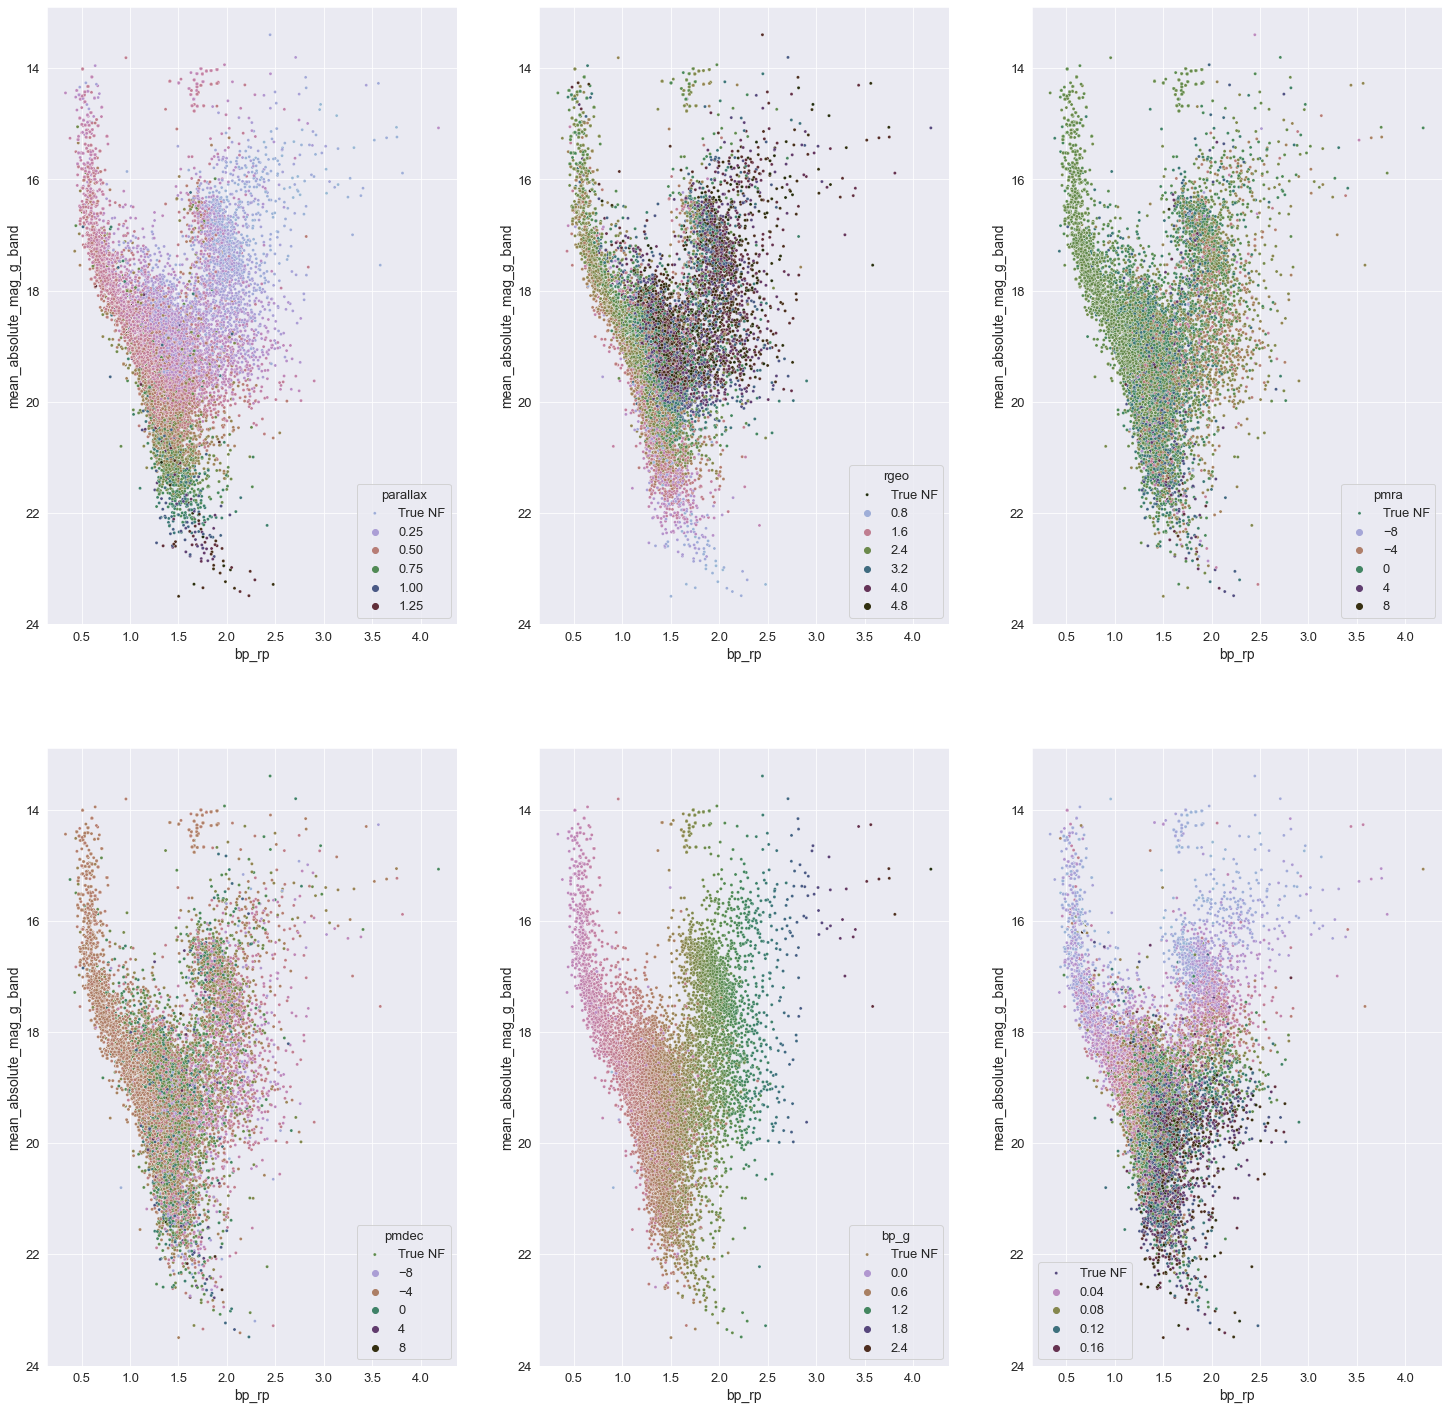

In [83]:
f, axes = plt.subplots(2, 3)
f.set_figheight(25)
f.set_figwidth(25)

scatter=nf_data
sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='parallax',ax=axes[0,0],s=10,label='True NF', palette="ch:r=-3,l=0.7")

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='rgeo',ax=axes[0,1],s=10,label='True NF', palette="ch:r=-3,l=0.7")

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='pmra',ax=axes[0,2],s=10,label='True NF', palette="ch:r=-3,l=0.7")

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='pmdec',ax=axes[1,0],s=10,label='True NF', palette="ch:r=-3,l=0.7")

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='bp_g',ax=axes[1,1],s=10,label='True NF', palette="ch:r=-3,l=0.7")

sn.scatterplot(data=scatter,x='bp_rp',y='mean_absolute_mag_g_band',hue='parallax_error',ax=axes[1,2],s=10,label='True NF', palette="ch:r=-3,l=0.7")

#axes.set_xlim(0,2.5)

plt.legend()
for i in range(0,2):
    for j in range(0,3):
        axes[i,j].invert_yaxis()
plt.show()

# Semisupervised Model Definition

In [84]:
from sklearn.preprocessing import  MinMaxScaler
import torch
scaler=MinMaxScaler()
column_names=['pmra', 'pmdec',
       'rgeo','mean_absolute_mag_g_band','labels']
#column_names=['ra','dec','pmra','pmdec','mean_absolute_mag_g_band','bp_g','g_rp','bp_rp']
#column_names=['mean_absolute_mag_g_band','bp_rp','ra','dec','rgeo','g_rp','pmra','pmdec','labels']
column_names=['mean_absolute_mag_g_band','bp_rp','bp_g','g_rp','rgeo','labels']
scaled_data=scaler.fit_transform(nf_data[column_names].values)

In [85]:
#%store scaler

In [86]:
batch_size = int(len(scaled_data)) #617 #factor for 1090
lr = 1e-3
epochs = 50

In [87]:
# Target distribution means
r = 1.5

x=[-r for i in range(len(column_names)-1)]

y=[r for i in range(len(column_names)-1)]

z=[(r)*((-1)**i) for i in range(len(column_names)-1)]

w=[r+(r)*((-1)**i) for i in range(len(column_names)-1)]

k=[-r+(r)*((-1)**(i+1)) for i in range(len(column_names)-1)]

means = torch.tensor([x,y,z])


from torch.utils.data import DataLoader
# Define distribution. 
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


X=DataLoader(torch.tensor(scaled_data).float(),batch_size=batch_size,drop_last=True) 
model = FlowGMM(layers=5,n_features=scaled_data[0].shape[-1]-1,mixture_components=3,hidden_dims=[500,25],d=3,means=means)

# Training hyperparameters.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [88]:
plot_loss=[]
plotll=[]
plotdet=[]
# Iterate over the number of iterations.
model.train()

for epoch in range(epochs):    
        overall_loss = 0
        for batch_idx, x in enumerate(X):

            x = x.view(batch_size, len(x[0]))
            #x = x.to(DEVICE)
            
            optimizer.zero_grad()

            y,gmm,loss,log_l,determinant,ll,det = model(x)
            
            
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        plot_loss.append(loss)   
        plotll.append(ll)  
        plotdet.append(det)   
        #print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
        print("ll: "+ str(ll))
        print("Overall Loss: ", overall_loss)
    
print("Finish!!")

/Users/mattocallaghan/GES/Data_handling/gmmflow.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


ll: tensor(-8.2982, grad_fn=<MeanBackward0>)
Overall Loss:  9.27820110321045
ll: tensor(-8.2753, grad_fn=<MeanBackward0>)
Overall Loss:  9.14368724822998
ll: tensor(-8.2533, grad_fn=<MeanBackward0>)
Overall Loss:  9.011167526245117
ll: tensor(-8.2324, grad_fn=<MeanBackward0>)
Overall Loss:  8.881134986877441
ll: tensor(-8.2129, grad_fn=<MeanBackward0>)
Overall Loss:  8.75442123413086
ll: tensor(-8.1947, grad_fn=<MeanBackward0>)
Overall Loss:  8.63022518157959
ll: tensor(-8.1773, grad_fn=<MeanBackward0>)
Overall Loss:  8.507298469543457
ll: tensor(-8.1604, grad_fn=<MeanBackward0>)
Overall Loss:  8.384883880615234
ll: tensor(-8.1435, grad_fn=<MeanBackward0>)
Overall Loss:  8.262493133544922
ll: tensor(-8.1263, grad_fn=<MeanBackward0>)
Overall Loss:  8.139840126037598
ll: tensor(-8.1077, grad_fn=<MeanBackward0>)
Overall Loss:  8.015632629394531
ll: tensor(-8.0860, grad_fn=<MeanBackward0>)
Overall Loss:  7.888359546661377
ll: tensor(-8.0574, grad_fn=<MeanBackward0>)
Overall Loss:  7.754118

In [89]:
import matplotlib.pyplot as plt
for i in range (len(plot_loss)):
    plot_loss[i]=plot_loss[i].detach().numpy()
    plotll[i]=plotll[i].detach().numpy()
    plotdet[i]=plotdet[i].detach().numpy()

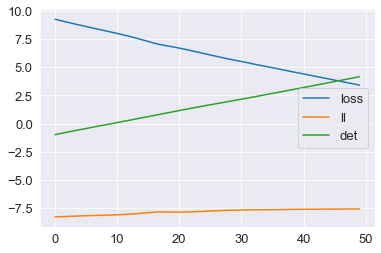

In [90]:
plt.plot(plot_loss,label='loss')
plt.plot(plotll,label='ll')
plt.plot(plotdet,label='det')
plt.legend()
plt.show()

In [91]:
os.chdir('../Data_handling')
#model=torch.load('model_2.pt')

In [92]:
y,gmm,loss,log_l,determinant,ll,det = model(torch.tensor(scaled_data).float())


/Users/mattocallaghan/GES/Data_handling/gmmflow.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))


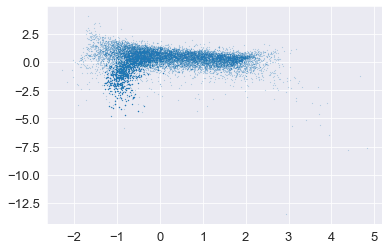

In [93]:
y,gmm,loss,log_l,determinant,ll,det = model(torch.tensor(scaled_data).float())
probs=gmm.class_probs(y).detach().numpy()
log_p=gmm.log_prob(y).detach().numpy()
y=y.detach().numpy()



plt.scatter(y.transpose()[0],y.transpose()[1],s=0.01)

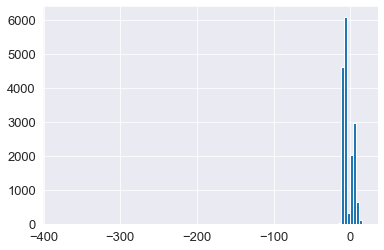

In [94]:
p=log_l.detach().numpy()+determinant.detach().numpy()
plt.hist((p).transpose(),bins=100)

plt.show()

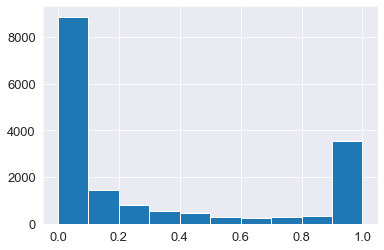

In [95]:
j=0
plt.hist(probs.transpose()[j])
plt.show()


In [96]:
column=[i for i in range(probs.shape[-1])]
df=pd.DataFrame(data=probs,columns=column)
plotdf=pd.concat([nf_data,df],axis=1)



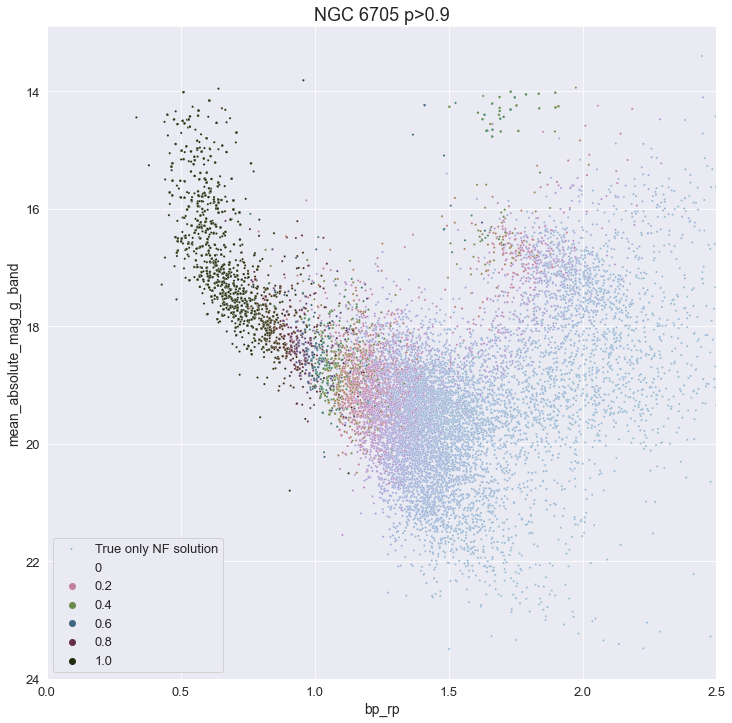

In [97]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=plotdf
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter[j],s=5,ax=axes,label='True only NF solution',color='b', palette="ch:r=-3,l=0.7")

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

In [98]:

p=0.9
data_for_hr1_full=plotdf[plotdf[j]>p]
data_for_hr2_full=plotdf[plotdf['prob']>p]
both_solution=data_for_hr1_full[data_for_hr1_full['prob']>p]

data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['prob']<=p]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full[j]<=p]

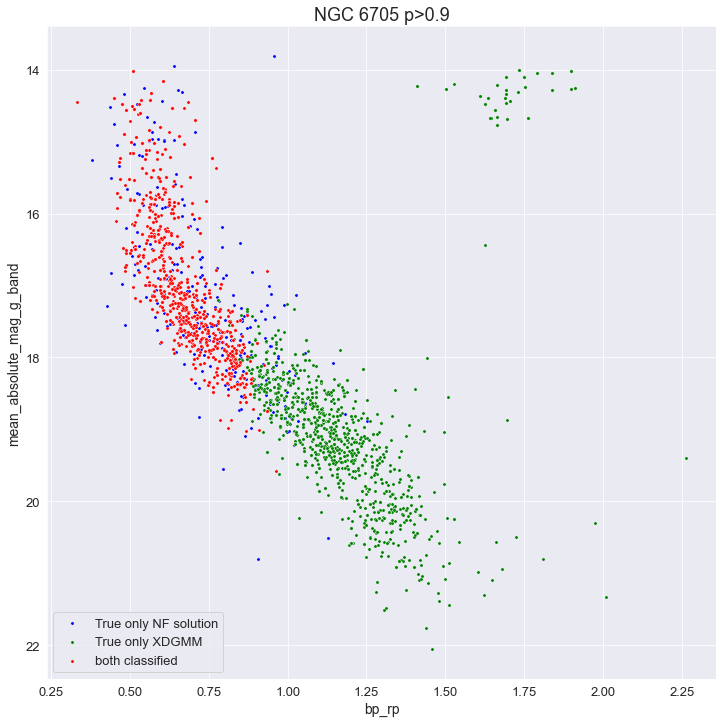

In [99]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True only NF solution',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only XDGMM',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

In [100]:
#torch.save(model,'model_no_giants2.pt')